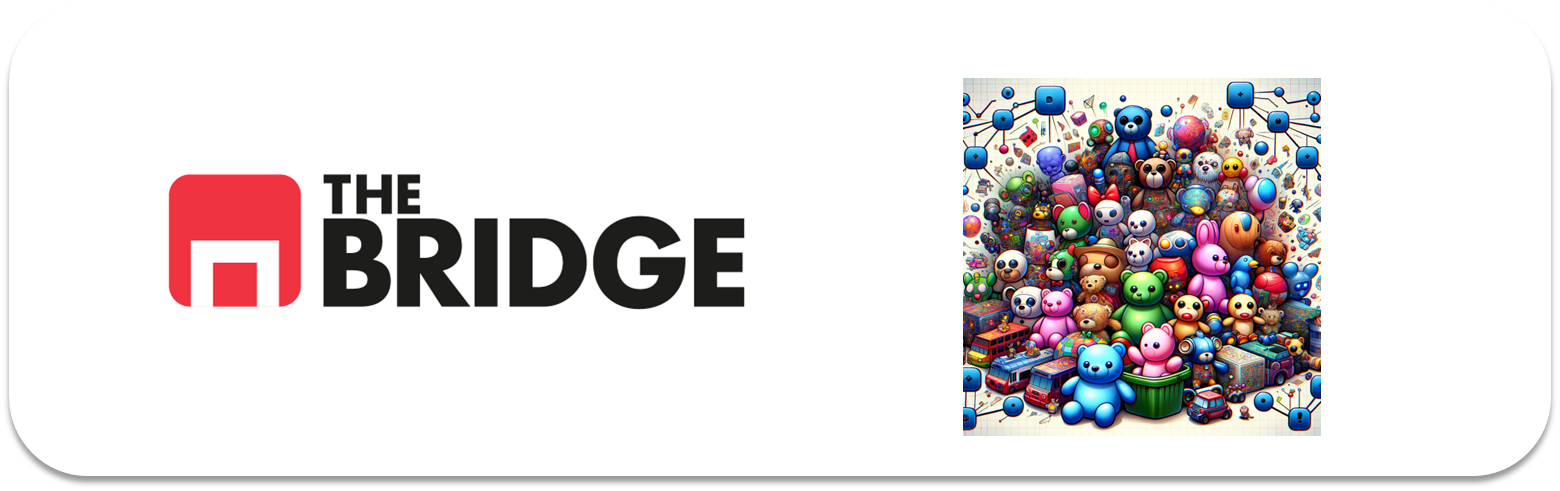

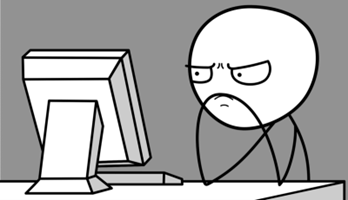

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [20]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [2]:
from sklearn.datasets import fetch_olivetti_faces

# Cargar el dataset de rostros Olivetti
faces = fetch_olivetti_faces()

# Mostrar la descripción del dataset
print(faces['DESCR'])

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Joaquín\scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [3]:
# Crear un DataFrame con las features y el target
df_faces = pd.DataFrame(faces.data)
df_faces['target'] = faces.target

# Reordenar aleatoriamente las imágenes
df_faces_shuffled = df_faces.sample(frac=1, random_state=42).reset_index(drop=True)

# Mostrar las primeras filas del DataFrame reordenado
print(df_faces_shuffled.head())

          0         1         2         3         4         5         6  \
0  0.198347  0.235537  0.351240  0.409091  0.421488  0.429752  0.500000   
1  0.185950  0.128099  0.115702  0.132231  0.185950  0.268595  0.433884   
2  0.508264  0.603306  0.619835  0.628099  0.657025  0.665289  0.690083   
3  0.136364  0.140496  0.185950  0.280992  0.318182  0.363636  0.409091   
4  0.652893  0.644628  0.652893  0.706612  0.714876  0.719008  0.743802   

          7         8         9  ...      4087      4088      4089      4090  \
0  0.528926  0.524793  0.553719  ...  0.508264  0.524793  0.504132  0.483471   
1  0.541322  0.570248  0.586777  ...  0.396694  0.409091  0.301653  0.421488   
2  0.727273  0.743802  0.768595  ...  0.301653  0.305785  0.314050  0.326446   
3  0.417355  0.438017  0.454545  ...  0.169421  0.206612  0.276859  0.355372   
4  0.747934  0.747934  0.756198  ...  0.074380  0.074380  0.082645  0.082645   

       4091      4092      4093      4094      4095  target  
0  0.4

### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [7]:
# Primer split 80-20 para obtener el conjunto de entrenamiento y el conjunto restante
train_df, temp_df = train_test_split(df_faces_shuffled, test_size=0.20, stratify=df_faces_shuffled['target'], random_state=42)

# Segundo split 50-50 sobre el conjunto restante para obtener los conjuntos de validación y pruebas
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['target'], random_state=42)

# Verificar las proporciones de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(val_df)}")
print(f"Tamaño del conjunto de pruebas: {len(test_df)}")

Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de pruebas: 40


### #1.4

Crea los pares X,y para train, validation y test.

In [8]:
# Crear los pares X, y para train, validation y test
X_train, y_train = train_df.drop(columns=['target']), train_df['target']
X_val, y_val = val_df.drop(columns=['target']), val_df['target']
X_test, y_test = test_df.drop(columns=['target']), test_df['target']

# Verificar las proporciones de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")
print(f"Tamaño del conjunto de pruebas: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de pruebas: 40


Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [9]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

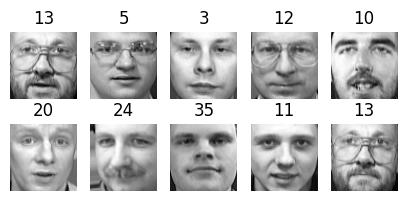

In [10]:
# Visualizar algunas caras del conjunto de entrenamiento
plot_faces(X_train.iloc[:10].values, y_train.iloc[:10].values)

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [12]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=0.95, random_state=42)  # Retener el 95% de la varianza

# Ajustar PCA en el conjunto de entrenamiento y transformar los datos
X_train_pca = pca.fit_transform(X_train)

# Transformar los conjuntos de validación y prueba
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Verificar las dimensiones de los conjuntos transformados
print(f"Dimensiones del conjunto de entrenamiento después de PCA: {X_train_pca.shape}")
print(f"Dimensiones del conjunto de validación después de PCA: {X_val_pca.shape}")
print(f"Dimensiones del conjunto de pruebas después de PCA: {X_test_pca.shape}")

Dimensiones del conjunto de entrenamiento después de PCA: (320, 111)
Dimensiones del conjunto de validación después de PCA: (40, 111)
Dimensiones del conjunto de pruebas después de PCA: (40, 111)


### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

El mejor k es: 125
El mejor score de silueta es: 0.23549623787403107


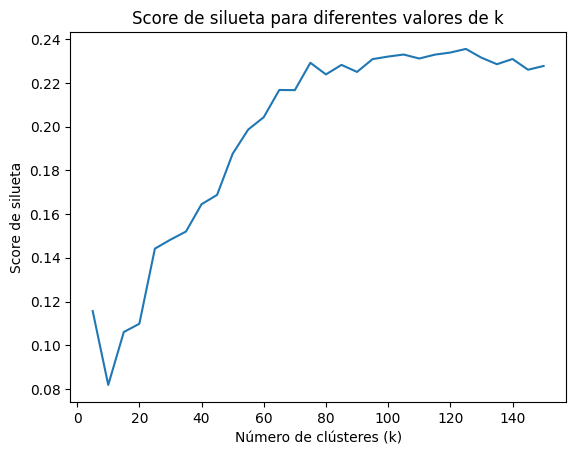

In [13]:

# Inicializar variables para almacenar los resultados
best_k = 0
best_score = -1
scores = []

# Probar diferentes valores de k (de 5 en 5 hasta 150)
for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    labels = kmeans.labels_
    score = silhouette_score(X_train_pca, labels)
    scores.append(score)
    
    if score > best_score:
        best_k = k
        best_score = score

# Mostrar el mejor k y el mejor score de silueta
print(f"El mejor k es: {best_k}")
print(f"El mejor score de silueta es: {best_score}")

# Opcional: Graficar los scores de silueta para cada k
plt.plot(range(5, 151, 5), scores)
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Score de silueta')
plt.title('Score de silueta para diferentes valores de k')
plt.show()

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

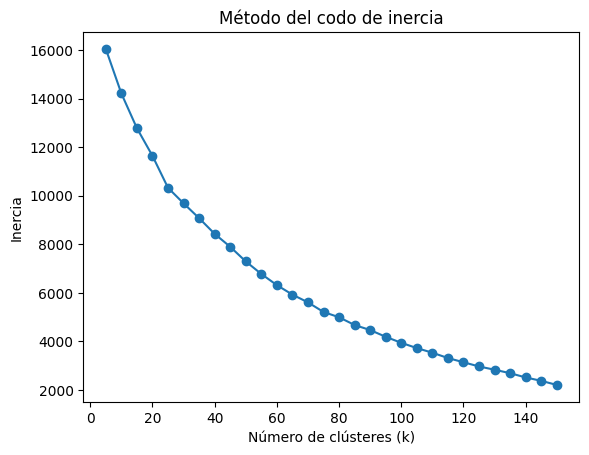

In [14]:
# Inicializar variables para almacenar los resultados
inertias = []

# Probar diferentes valores de k (de 5 en 5 hasta 150)
for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    inertias.append(kmeans.inertia_)

# Graficar la inercia para cada k
plt.plot(range(5, 151, 5), inertias, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del codo de inercia')
plt.show()

### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [17]:
# Inicializar variables para almacenar los resultados
best_k = 0
best_score = -1
scores = []

# Probar diferentes valores de k (de 5 en 5 hasta 150)
for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    labels = kmeans.labels_
    score = silhouette_score(X_train_pca, labels)
    scores.append(score)
    
    if score > best_score:
        best_k = k
        best_score = score

# Mostrar el mejor k y el mejor score de silueta
print(f"El mejor k es: {best_k}")
print(f"El mejor score de silueta es: {best_score}")

# Asignar el modelo con el mejor k a la variable best_model
best_model = KMeans(n_clusters=best_k, random_state=42)
best_model.fit(X_train_pca)

El mejor k es: 125
El mejor score de silueta es: 0.23549623787403107


KMeans(n_clusters=125, random_state=42)

### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

Clúster 0


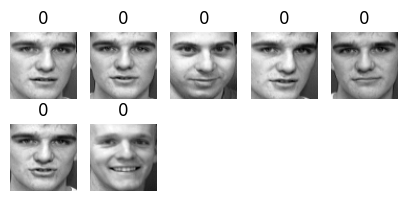

Clúster 1


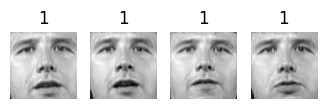

Clúster 2


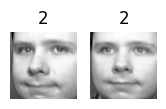

Clúster 3


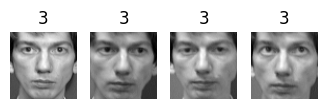

Clúster 4


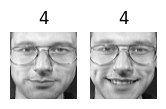

Clúster 5


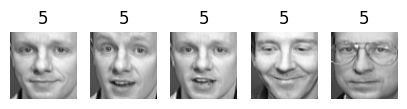

Clúster 6


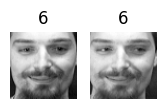

Clúster 7


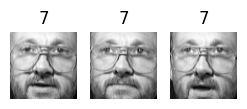

Clúster 8


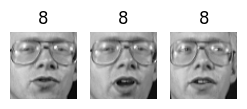

Clúster 9


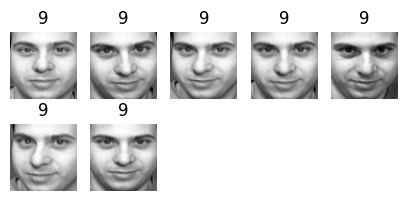

In [18]:
# Obtener las etiquetas de los clústeres asignadas por best_model
labels = best_model.labels_

# Crear una función para visualizar las caras de los 10 primeros clústeres
def plot_cluster_faces(X_original, labels, cluster_num, n_cols=5):
    cluster_faces = X_original[labels == cluster_num]
    plot_faces(cluster_faces, [cluster_num] * len(cluster_faces), n_cols=n_cols)

# Visualizar las caras asignadas a los 10 primeros clústeres
for cluster_num in range(10):
    print(f"Clúster {cluster_num}")
    plot_cluster_faces(X_train.values, labels, cluster_num)

## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [21]:
# Entrenar el clasificador RandomForest con 150 estimadores
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rf_clf.fit(X_train, y_train)

# Predecir las etiquetas en el conjunto de validación
y_val_pred = rf_clf.predict(X_val)

# Evaluar el modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Exactitud del modelo en el conjunto de validación: {accuracy:.2f}")

Exactitud del modelo en el conjunto de validación: 0.93


### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [22]:
X_train_reduced = best_model.transform(X_train_pca) 


In [23]:
# Obtener las distancias de cada punto a los centroides utilizando el modelo best_model
X_train_reduced = best_model.transform(X_train_pca)
X_val_reduced = best_model.transform(X_val_pca)
X_test_reduced = best_model.transform(X_test_pca)

# Entrenar el clasificador RandomForest con 150 estimadores en el conjunto reducido
rf_clf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
rf_clf_reduced.fit(X_train_reduced, y_train)

# Predecir las etiquetas en el conjunto de validación reducido
y_val_pred_reduced = rf_clf_reduced.predict(X_val_reduced)

# Evaluar el modelo en el conjunto de validación reducido
accuracy_reduced = accuracy_score(y_val, y_val_pred_reduced)
print(f"Exactitud del modelo en el conjunto de validación reducido: {accuracy_reduced:.2f}")

Exactitud del modelo en el conjunto de validación reducido: 0.78


### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

El mejor k es: 90
El mejor rendimiento (accuracy) en el conjunto de validación es: 0.82


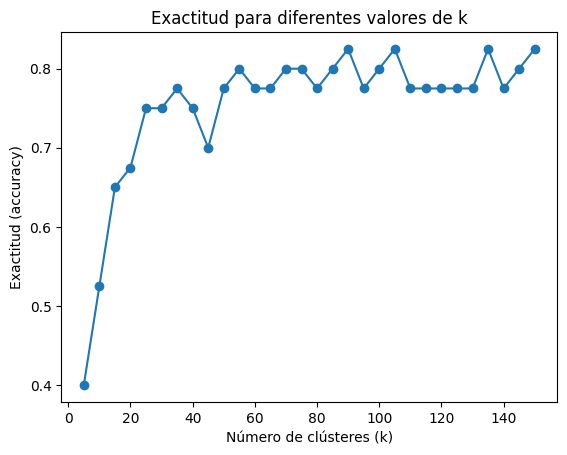

In [24]:
# Inicializar variables para almacenar los resultados
best_k = 0
best_accuracy = 0
accuracies = []

# Probar diferentes valores de k (de 5 en 5 hasta 150)
for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    
    # Obtener las distancias de cada punto a los centroides
    X_train_reduced = kmeans.transform(X_train_pca)
    X_val_reduced = kmeans.transform(X_val_pca)
    
    # Entrenar el clasificador RandomForest con 150 estimadores en el conjunto reducido
    rf_clf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
    rf_clf_reduced.fit(X_train_reduced, y_train)
    
    # Predecir las etiquetas en el conjunto de validación reducido
    y_val_pred_reduced = rf_clf_reduced.predict(X_val_reduced)
    
    # Evaluar el modelo en el conjunto de validación reducido
    accuracy_reduced = accuracy_score(y_val, y_val_pred_reduced)
    accuracies.append(accuracy_reduced)
    
    if accuracy_reduced > best_accuracy:
        best_k = k
        best_accuracy = accuracy_reduced

# Mostrar el mejor k y el mejor rendimiento en términos de exactitud
print(f"El mejor k es: {best_k}")
print(f"El mejor rendimiento (accuracy) en el conjunto de validación es: {best_accuracy:.2f}")

# Opcional: Graficar las accuracies para cada k
plt.plot(range(5, 151, 5), accuracies, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Exactitud (accuracy)')
plt.title('Exactitud para diferentes valores de k')
plt.show()